In [1]:
%matplotlib inline
from fns import *
from fns.functionsTF import *

/home/gp1514/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


********************************************************************************
functionsTF loaded!
********************************************************************************


In [2]:
config = load_config()

res = []
T = 5000

# run two simulations, first without shared gap junctions, then with 40 shared gap junctions
for sG in [0,40]:
    gpu = TfConnEvolveNet(config=config, T=T)

    # number of cross-network gap junctions
    gpu.sG = sG

    NE = 800
    NI = 200
    ## input network
    # number of excitatory neurons
    gpu.NE1=NE
    # number of inhibitory neurons
    gpu.NI1=NI

    ## gamma network
    # number of excitatory neurons
    gpu.NE2=NE
    # number of inhibitory neurons
    gpu.NI2=NI

    ### input to the input-network
    seed = 0
    # input amplitude
    A = 400
    x = generateInput2(seed, T, tau=100)[np.newaxis, :]
    w0 = np.random.rand(1, 2*(NE+NI)) * 2
    w0 = w0 * A
    w0 = w0 * np.concatenate([np.ones((1, NE+NI)), np.zeros((1, NE+NI))], axis=1)
    INP = w0.T @ x + 200

    ### small constant drive to the output-network
    # k = np.ones((1, T)) * 200
    # w1 = np.concatenate([np.zeros((1, NE+NI)), np.ones((1, NE+NI))], axis=1)
    # INP2 = w1.T @ k

    # feed input to network
    gpu.input = INP 

    # choose hardware
    gpu.device = '/gpu:0'

    # mean initial gap junction coupling
    gpu.g1 = 5.5
    gpu.g2 = 5.5

    # do not save the spikes
    gpu.spikeMonitor = False
    # do not save the individual voltages, currents, etc.
    gpu.monitor_single = False

    # iteration 
    gpu.stabTime = np.inf

    # rule: g0 = 0 for no bound rule, g0 = 10 for softbound rule
    gpu.g0 = 10

    gpu.runTFSimul()

    res.append(gpu)
    del gpu
    gc.collect()

1000 800 200
1000 800 200


100%|██████████| 5000/5000 [00:29<00:00, 172.18it/s]



29.36

1000 800 200
1000 800 200


100%|██████████| 5000/5000 [00:28<00:00, 174.34it/s]



28.95



## Reconstruction input

-0.387380020334
0.921937687734


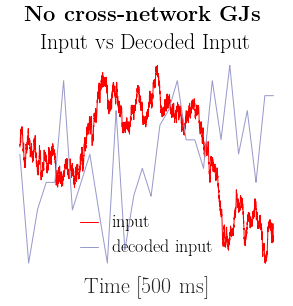

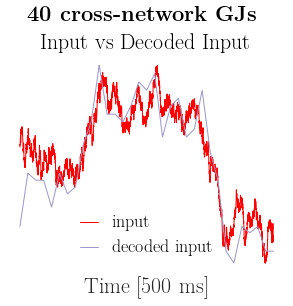

In [3]:
s = 0
e = T

for i in range(2):
    f(5,4)
    # input signal to input-network
    inp = res[i].input[0,s:e]/np.max(res[i].input[0,s:e])
    # population activity of inhibitory neurons of the output-network
    ifr = res[i].vvmI2[s:e] 

    spikes, xdec, ydec, corr_predict = decode(inp, ifr )
    
    # rescale signals for plotting
    inp -= np.min(inp)
    inp /= np.max(inp)
    ydec -= np.min(ydec)
    ydec /= np.max(ydec)
    
    # plot input
    plt.plot(xdec, inp, color='r', label='input')
    # plot decoded input
    plt.plot(xdec,ydec, color=snCol, label='decoded input')
    plt.xticks([])
    plt.yticks([])
    plt.legend(fontsize=18, loc='best', handlelength=1)
    plt.xlabel('Time [%d ms]'%int((e-s)*res[i].dt))
    plt.title('Input vs Decoded Input')
    if i==0:
        plt.suptitle(r'\textbf{No cross-network GJs}', y=1.05, fontsize=22)
    else:
        plt.suptitle(r'\textbf{40 cross-network GJs}', y=1.05, fontsize=22)

    print(np.corrcoef(ydec,res[i].input[0,s:e])[0,1])